## **Weather Forecasting Module**

Fetch daily weather history via the free Open-Meteo API, turn it into a pandas DataFrame, and leave a clean hook for later modeling (AR/MA).

In [1]:
import requests
import pandas as pd
from datetime import date, timedelta

# Convenience: default to the last ~90 days if no dates are supplied later
DEFAULT_END = date.today()
DEFAULT_START = DEFAULT_END - timedelta(days=89)


## **Data Collection**

In [2]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using Open-Meteo's free geocoding API."""
    url = "https://geocoding-api.open-meteo.com/v1/search"
    resp = requests.get(url, params={"name": city, "count": 1, "language": "en"}, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    results = data.get("results") or []
    if not results:
        raise ValueError(f"No geocoding results for '{city}'")
    lat = results[0]["latitude"]
    lon = results[0]["longitude"]
    return lat, lon


In [3]:
def fetch_weather_timeseries(city: str, start: date | None = None, end: date | None = None) -> pd.DataFrame:
    """
    Fetch daily weather history (avg/min/max temp, precip) for a city into a DataFrame.

    Uses Open-Meteo's archive API. Dates are inclusive and must be in YYYY-MM-DD.
    """
    start = start or DEFAULT_START
    end = end or DEFAULT_END
    if start > end:
        raise ValueError("start date must be <= end date")

    lat, lon = geocode_city(city)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start.isoformat(),
        "end_date": end.isoformat(),
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
        ],
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=20)
    resp.raise_for_status()
    data = resp.json()

    # Build DataFrame safely
    daily = data.get("daily", {})
    df = pd.DataFrame(daily)
    if df.empty:
        raise ValueError("No weather data returned; check dates or API availability")

    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )
    return df


In [4]:
# Example: pull the last ~30 days for New York City
try:
    weather_df = fetch_weather_timeseries("Dubai")
    display(weather_df.head())
    display(weather_df.tail(3))
    print(f"Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
except Exception as exc:
    print(f"Fetch failed: {exc}")


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-09-14,39.0,28.7,33.2,0.0
2025-09-15,38.3,28.5,32.8,0.0
2025-09-16,39.3,29.4,33.3,0.0
2025-09-17,39.7,28.8,33.3,0.0
2025-09-18,40.5,27.7,32.9,0.0


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-10,30.1,15.1,22.2,0.0
2025-12-11,29.8,15.5,22.3,0.0
2025-12-12,29.7,16.5,22.8,0.0


Fetched 90 days spanning 2025-09-14 to 2025-12-12


## **Auto-Regressive Model**

In [5]:
# AR modeling prep
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Use mean daily temperature; drop any missing values
series = weather_df["temp_mean_c"].dropna()
series.name = "temp_mean_c"
print(f"Series length: {len(series)} days")
series.head()


Series length: 90 days


time
2025-09-14    33.2
2025-09-15    32.8
2025-09-16    33.3
2025-09-17    33.3
2025-09-18    32.9
Name: temp_mean_c, dtype: float64

In [11]:
# Train/test split
train_size = int(len(series) * 0.7)
train, test = series.iloc[:train_size], series.iloc[train_size:]
print(f"Train: {len(train)} samples, Test: {len(test)} samples")

# Fit a simple AutoReg model with 7 lags (weekly pattern)
lag = 7
ar_model = AutoReg(train, lags=lag, old_names=False).fit()
print(ar_model.summary())


Train: 62 samples, Test: 28 samples
                            AutoReg Model Results                             
Dep. Variable:            temp_mean_c   No. Observations:                   62
Model:                     AutoReg(7)   Log Likelihood                 -44.992
Method:               Conditional MLE   S.D. of innovations              0.548
Date:                Fri, 12 Dec 2025   AIC                            107.985
Time:                        16:59:29   BIC                            126.051
Sample:                    09-21-2025   HQIC                           114.971
                         - 11-14-2025                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7938      1.095     -0.725      0.468      -2.940       1.352
temp_mean_c.L1     0.8353      0.122      6.868      0.000       0.597       1.074


/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [12]:
# In-sample and out-of-sample predictions for the test window
start = len(train)
end = len(series) - 1
pred_test = ar_model.predict(start=start, end=end, dynamic=False)

# Evaluation metrics
mae = np.mean(np.abs(pred_test - test))
rmse = np.sqrt(np.mean((pred_test - test) ** 2))
print(f"MAE: {mae:.3f} °C | RMSE: {rmse:.3f} °C")


MAE: 1.317 °C | RMSE: 1.776 °C


/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


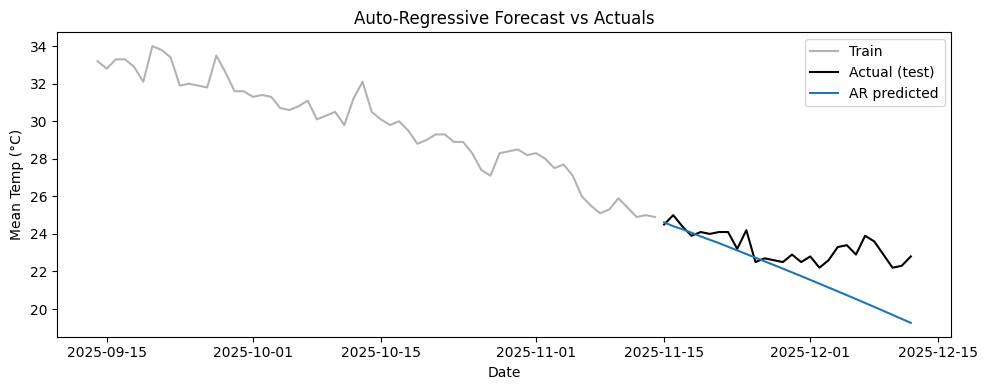

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


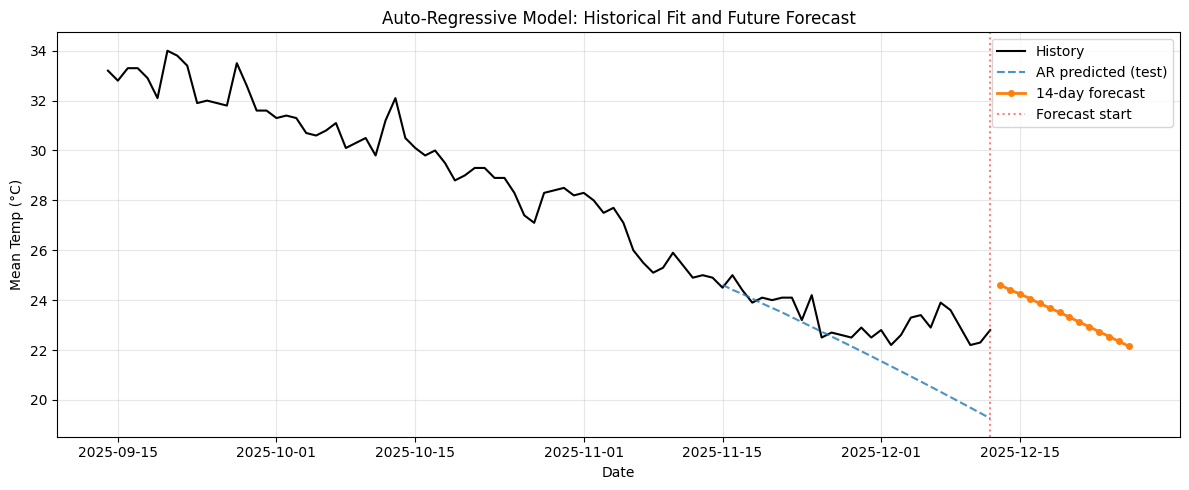


14-Day Forecast:


,Date,Forecasted Temp (°C)
2025-11-15,2025-12-13,24.613554
2025-11-16,2025-12-14,24.411755
2025-11-17,2025-12-15,24.249932
2025-11-18,2025-12-16,24.064494
2025-11-19,2025-12-17,23.865763
2025-11-20,2025-12-18,23.687441
2025-11-21,2025-12-19,23.509573
2025-11-22,2025-12-20,23.316332
2025-11-23,2025-12-21,23.121200
2025-11-24,2025-12-22,22.928137


In [13]:
# Plot actual vs predicted on the held-out test set
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label="Train", color="gray", alpha=0.6)
plt.plot(test.index, test, label="Actual (test)", color="black")
plt.plot(test.index, pred_test, label="AR predicted", color="tab:blue")
plt.title("Auto-Regressive Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Mean Temp (°C)")
plt.legend()
plt.tight_layout()
plt.show()

# Multi-step forecast beyond the observed data using forecast() method
# This method is designed for out-of-sample forecasting
future_horizon = 14
future_forecast = ar_model.forecast(steps=future_horizon)
future_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=future_horizon, freq="D")

plt.figure(figsize=(12, 5))
plt.plot(series.index, series, label="History", color="black", linewidth=1.5)
plt.plot(test.index, pred_test, label="AR predicted (test)", color="tab:blue", alpha=0.8, linestyle="--")
plt.plot(future_index, future_forecast, label=f"{future_horizon}-day forecast", color="tab:orange", linewidth=2, marker="o", markersize=4)
plt.axvline(x=series.index[-1], color="red", linestyle=":", alpha=0.5, label="Forecast start")
plt.title("Auto-Regressive Model: Historical Fit and Future Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temp (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n14-Day Forecast:")
forecast_df = pd.DataFrame({"Date": future_index, "Forecasted Temp (°C)": future_forecast})
display(forecast_df)
